In [12]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from transformers import BertTokenizer, BertModel

# Add Q2/functions to sys.path whether the notebook runs from repo root or /Q2
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q2" / "functions"

sys.path.insert(0, str(functions_dir))

from eval_utils import evaluate_model

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [13]:
import transformers
import accelerate
import peft
import datasets

In [14]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch

from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)

from peft import LoraConfig, get_peft_model, TaskType


In [15]:
SEED = 42
set_seed(SEED)

# Resolve paths whether running from repo root or from /Q2
cwd = Path.cwd()
if (cwd / "train_df_processed.csv").exists():
    train_path = cwd / "train_df_processed.csv"
    test_path = cwd / "test_df_processed.csv"
else:
    train_path = cwd.parent / "train_df_processed.csv"
    test_path = cwd.parent / "test_df_processed.csv"

train_df = pd.read_csv(train_path).dropna(subset=["processed_text", "sentiment_class"])
test_df  = pd.read_csv(test_path).dropna(subset=["processed_text", "sentiment_class"])

X_text = train_df["processed_text"].astype(str).values
y = train_df["sentiment_class"].astype(int).values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=SEED, stratify=y
)

X_test_text = test_df["processed_text"].astype(str).values
y_test = test_df["sentiment_class"].astype(int).values

num_labels = len(np.unique(y_train))
print("num_labels:", num_labels)


num_labels: 3


In [16]:
from datasets import Dataset

MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

train_ds = Dataset.from_dict({"text": X_train_text.tolist(), "label": y_train.tolist()})
val_ds   = Dataset.from_dict({"text": X_val_text.tolist(),   "label": y_val.tolist()})
test_ds  = Dataset.from_dict({"text": X_test_text.tolist(),  "label": y_test.tolist()})

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH,
    )

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tokenize_fn, batched=True, remove_columns=["text"])

# Important: Trainer expects the label column to be named "labels"
train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/21970 [00:00<?, ? examples/s]

Map:   0%|          | 0/5493 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
).to(device)


Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],
)

model = get_peft_model(model, lora_config)

# Show how many parameters are trainable
model.print_trainable_parameters()


trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [19]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }


In [20]:
output_dir = "outputs/q7_lora"
os.makedirs(output_dir, exist_ok=True)

args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


C:\Users\jdani\AppData\Local\Temp\ipykernel_8256\2535070876.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.667400,0.609316,0.753687,0.755889
2,0.624500,0.588349,0.771527,0.772965
3,0.560800,0.590019,0.763881,0.766222


TrainOutput(global_step=4122, training_loss=0.6388335519482475, metrics={'train_runtime': 354.8575, 'train_samples_per_second': 185.737, 'train_steps_per_second': 11.616, 'total_flos': 1092524018456376.0, 'train_loss': 0.6388335519482475, 'epoch': 3.0})

Z:\Proyectos\Data\LLM-Based-Sentiment-Analysis\Q2\functions\eval_utils.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports_q2_lora/BERT_+_LoRA_(SEQ_CLS)_Full_Report.png


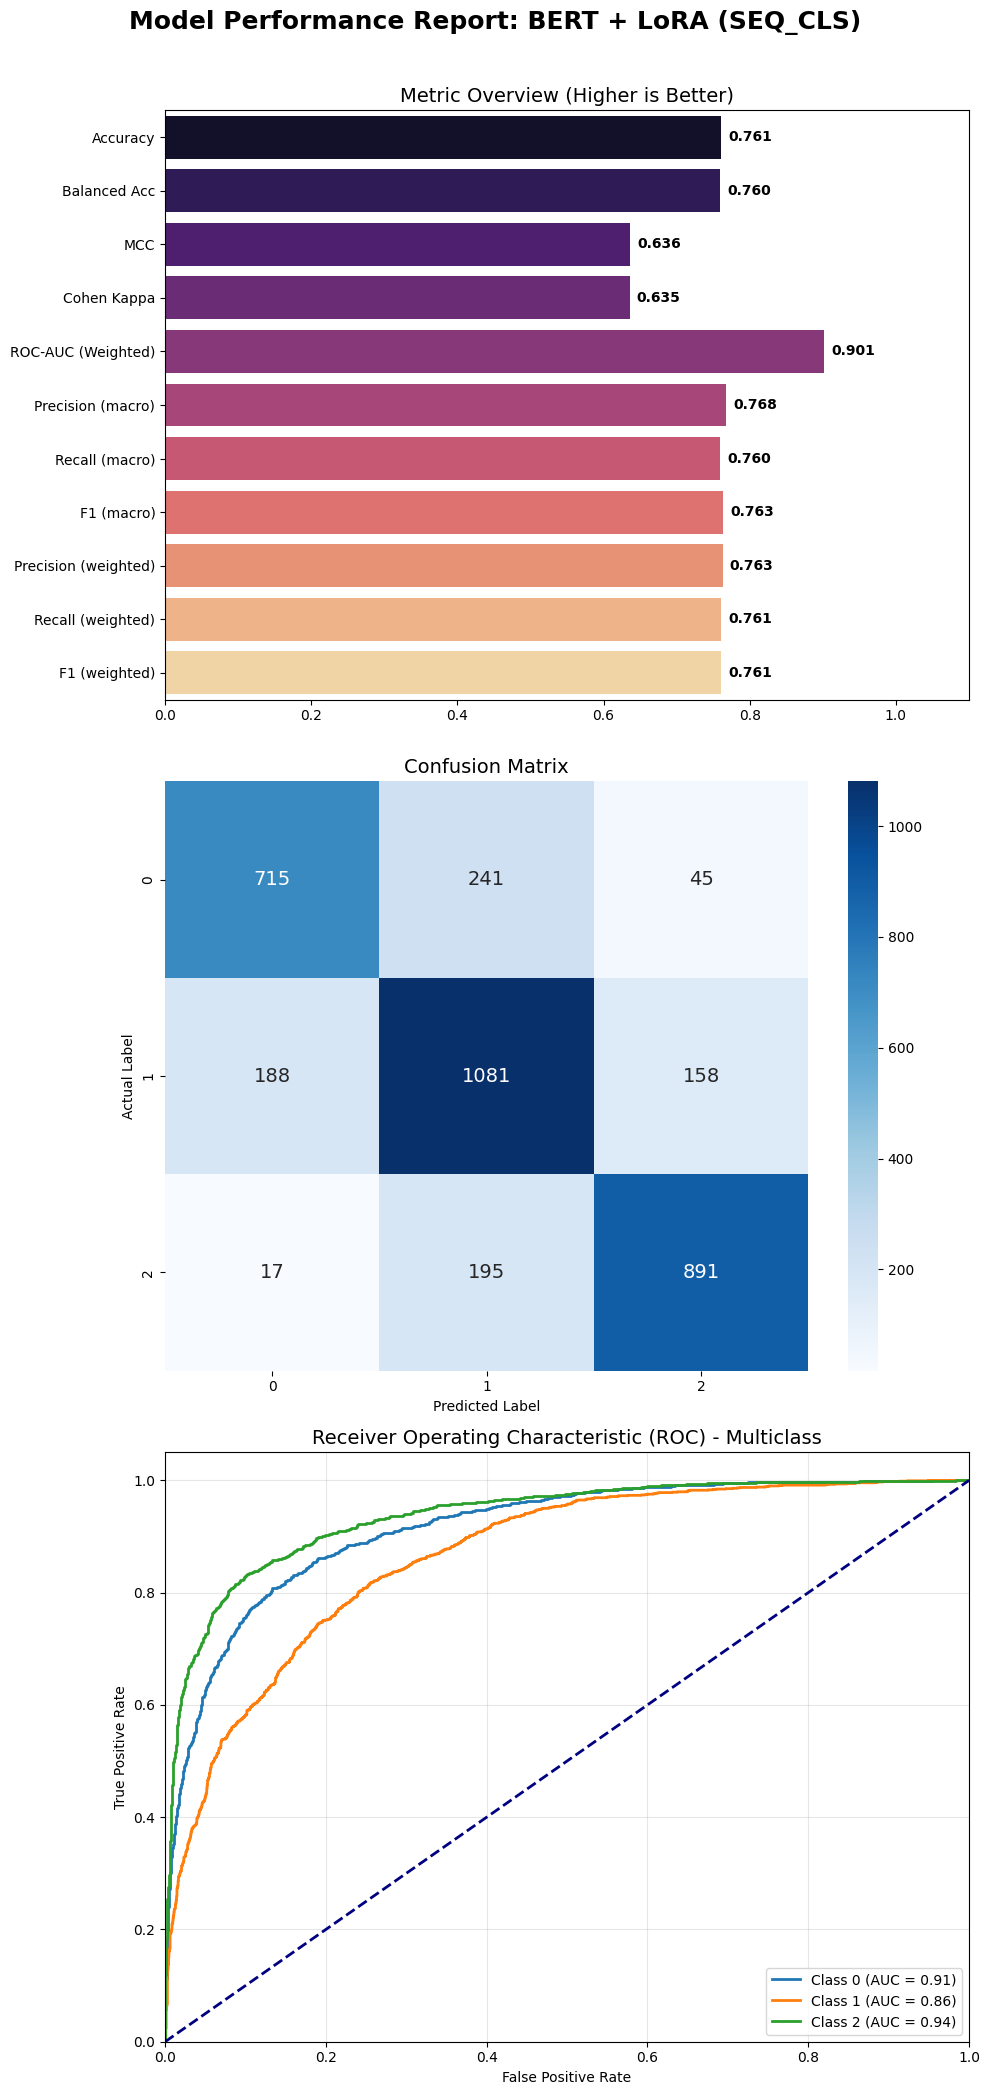

In [21]:
# Predict on test
pred_out = trainer.predict(test_ds)
logits = pred_out.predictions
labels = pred_out.label_ids

# Convert logits -> probabilities (softmax)
exp = np.exp(logits - logits.max(axis=1, keepdims=True))
probs = exp / exp.sum(axis=1, keepdims=True)

y_pred = probs.argmax(axis=1)
y_true = labels

# Reuse your existing Q1/Q2 evaluation report
# Ensure eval_utils.py is on path, like you already do in Q2.
from eval_utils import evaluate_model

os.makedirs("reports_q2_lora", exist_ok=True)
evaluate_model(
    y_true=y_true,
    y_pred=y_pred,
    y_probs=probs,
    model_name="BERT + LoRA (SEQ_CLS)",
    output_path="reports_q2_lora",
)
